# HNLQ: Part-03

In this part-03 notebook, we will encode and decode, and look at several decoding options

In [8]:
import sys
sys.path.append('../../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gemvq.quantizers.hnlq import HNLQ as Quantizer
from gemvq.quantizers.hnlq import HNLQConfig as QuantizerConfig


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Create Z² hierarchical quantizer
quantizer = Quantizer.create_z2_quantizer(
    q=2,
    M=3,
    overload=False,
    decoding='full',
    with_tie_dither=True
)

In [11]:
x = np.array([2,-5])
enc, T = quantizer.encode(x)
xh = quantizer.decode(enc, T)

print('x = ', x)
print('xh = ', xh)

print('Encoding vectors:')
# encode will have M levels of encoding vectors
for i in range(quantizer.M):
    print(f'\t at depth {i} = {enc[i]}')

# let us look at the reconstruction at each depth
print('Decode from coarse to fine:')
for i in range(quantizer.M):
    xh_mr = quantizer.decode_coarse_to_fine(enc, T, depth=i+1)
    print(f'\t Reconstruction at depth {i+1}:')
    print(f'\t xh = {xh_mr} at {i+1} bits per dimension')
    print(f'\t error = {xh_mr - x}')

# decode progressive is same as above but returns a list of reconstructions
print('Decode from coarse to fine but all at once')
xh_pr = quantizer.decode_progressive(enc, T)
for i in range(quantizer.M):
    print(f'\t Reconstruction at depth {i+1}:')
    print(f'\t xh = {xh_pr[i]} at {i+1} bits per dimension')
    xh_mr = quantizer.decode_coarse_to_fine(enc, T, depth=i+1)
    print(f'\t xh_mr = {xh_mr} at {i+1} bits per dimension')

x =  [ 2 -5]
xh =  [ 2. -5.]
Encoding vectors:
	 at depth 0 = [0 1]
	 at depth 1 = [1 0]
	 at depth 2 = [0 1]
Decode from coarse to fine:
	 Reconstruction at depth 1:
	 xh = [ 0. -4.] at 1 bits per dimension
	 error = [-2.  1.]
	 Reconstruction at depth 2:
	 xh = [ 2. -4.] at 2 bits per dimension
	 error = [0. 1.]
	 Reconstruction at depth 3:
	 xh = [ 2. -5.] at 3 bits per dimension
	 error = [0. 0.]
Decode from coarse to fine but all at once
	 Reconstruction at depth 1:
	 xh = [ 0. -4.] at 1 bits per dimension
	 xh_mr = [ 0. -4.] at 1 bits per dimension
	 Reconstruction at depth 2:
	 xh = [ 2. -4.] at 2 bits per dimension
	 xh_mr = [ 2. -4.] at 2 bits per dimension
	 Reconstruction at depth 3:
	 xh = [ 2. -5.] at 3 bits per dimension
	 xh_mr = [ 2. -5.] at 3 bits per dimension


We notice that as Rate (M) increases, the recontruction improves. We will run this a batch of inputs. See that as M increases, reconstruction quality improves.

Generating 1000 samples and tracking errors at depths 1 to 5...
Processing sample 0/1000
Processing sample 100/1000
Processing sample 200/1000
Processing sample 300/1000
Processing sample 400/1000
Processing sample 500/1000
Processing sample 600/1000
Processing sample 700/1000
Processing sample 800/1000
Processing sample 900/1000

=== Results Summary ===
   Depth  Mean_Error   Std_Error  Median_Error  Bits_per_Dimension
0      1  240.877018  108.604169    209.492757                   1
1      2   64.136750   28.470066     55.568718                   2
2      3   15.705898    7.059479     13.678989                   3
3      4    3.850917    1.672421      3.314196                   4
4      5    0.927425    0.377446      0.774939                   5


/var/folders/vl/8_b839fx467b9mn0g_w2wb8r0000gn/T/ipykernel_38168/3250430987.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors_at_depth[:, i] for i in range(M)],


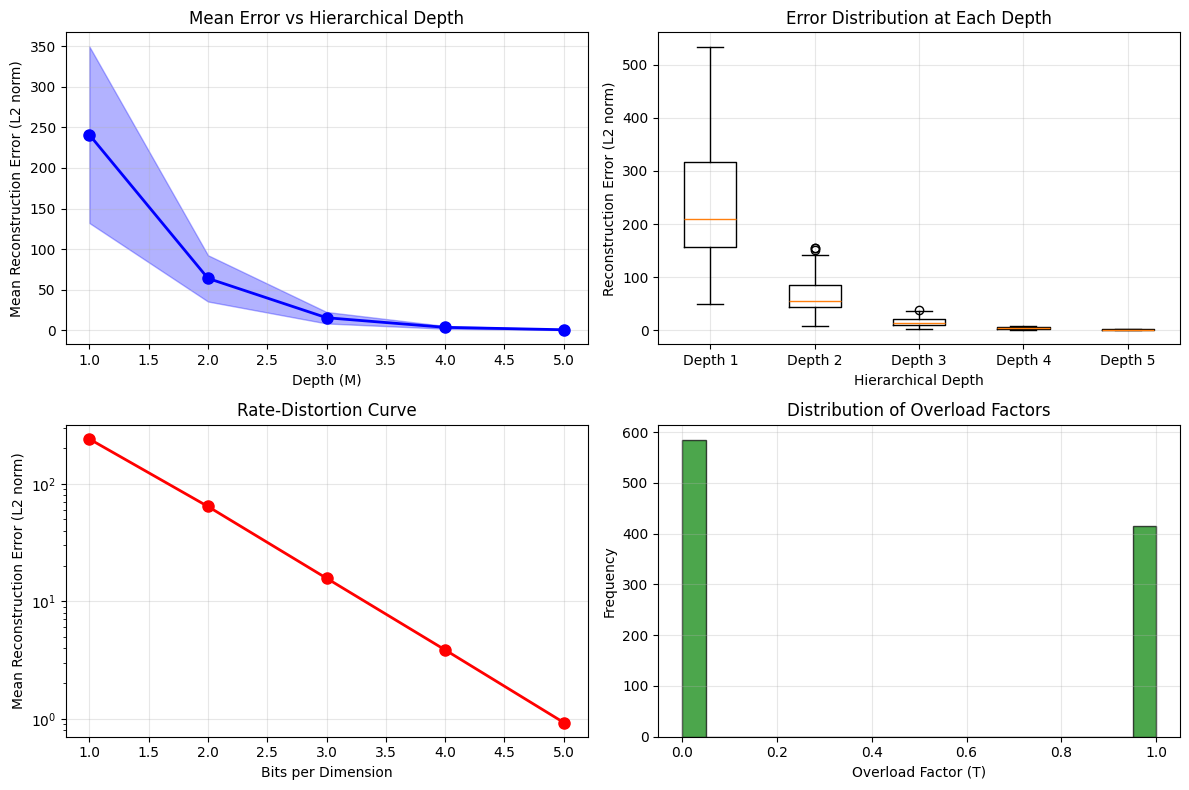


=== Additional Statistics ===
Average overload factor: 0.415
Std overload factor: 0.493
Max overload factor: 1.0
Min overload factor: 0.0
Perfect reconstructions at full depth: 0/1000 (0.0%)

=== Progressive Improvement Analysis ===
Depth 1 → 2: Error reduction = 176.740268 (3.76x improvement)
Depth 2 → 3: Error reduction = 48.430852 (4.08x improvement)
Depth 3 → 4: Error reduction = 11.854982 (4.08x improvement)
Depth 4 → 5: Error reduction = 2.923492 (4.15x improvement)


In [12]:
# Set random seed for reproducibility
np.random.seed(31)

# Configuration parameters
N = 1000  # Number of samples
M = 5     # Maximum number of hierarchical levels
q = 4     # Quantization parameter
d = 4     # Dimension (for D4 lattice)

# Create HNLQ quantizer configuration
config = QuantizerConfig(
    lattice_type='D4',
    q=q,
    M=M,
    beta=1.0,
    alpha=1.0,
    overload=True,
    decoding='full',
    with_tie_dither=True
)

# Create quantizer
quantizer = Quantizer(config)

# Generate N random samples, normalize to norm 1, then scale by q^M
samples_raw = np.random.normal(0, 1.0, size=(N, d))
# Normalize each sample to unit norm
samples_normalized = samples_raw / np.linalg.norm(samples_raw, axis=1, keepdims=True)
# Scale by q^M
pre_scale = q ** (M)/np.sqrt(2)
samples = samples_normalized * pre_scale

# Initialize arrays to store errors at different depths
errors_at_depth = np.zeros((N, M))
overload_factors = np.zeros(N)

print(f"Generating {N} samples and tracking errors at depths 1 to {M}...")

# Process each sample
for i in range(N):
    if i % 100 == 0:
        print(f"Processing sample {i}/{N}")
    
    x = samples[i]
    
    # Encode the sample
    enc, T = quantizer.encode(x)
    overload_factors[i] = T
    
    # Track errors at each depth from 1 to M
    for depth in range(1, M + 1):
        # Decode at specific depth
        xh = quantizer.decode_with_depth(enc, T, depth=depth)
        
        # Calculate error (L2 norm)
        error = np.linalg.norm(x - xh)
        errors_at_depth[i, depth - 1] = error

# Calculate statistics
mean_errors = np.mean(errors_at_depth, axis=0)
std_errors = np.std(errors_at_depth, axis=0)
median_errors = np.median(errors_at_depth, axis=0)

# Create results DataFrame
results_df = pd.DataFrame({
    'Depth': range(1, M + 1),
    'Mean_Error': mean_errors,
    'Std_Error': std_errors,
    'Median_Error': median_errors,
    'Bits_per_Dimension': range(1, M + 1)  # Each depth adds 1 bit per dimension
})

print("\n=== Results Summary ===")
print(results_df)

# Plotting
plt.figure(figsize=(12, 8))

# Plot 1: Mean error vs depth
plt.subplot(2, 2, 1)
plt.plot(range(1, M + 1), mean_errors, 'bo-', linewidth=2, markersize=8)
plt.fill_between(range(1, M + 1), 
                 mean_errors - std_errors, 
                 mean_errors + std_errors, 
                 alpha=0.3, color='blue')
plt.xlabel('Depth (M)')
plt.ylabel('Mean Reconstruction Error (L2 norm)')
plt.title('Mean Error vs Hierarchical Depth')
plt.grid(True, alpha=0.3)

# Plot 2: Error distribution at each depth
plt.subplot(2, 2, 2)
plt.boxplot([errors_at_depth[:, i] for i in range(M)], 
            labels=[f'Depth {i+1}' for i in range(M)])
plt.xlabel('Hierarchical Depth')
plt.ylabel('Reconstruction Error (L2 norm)')
plt.title('Error Distribution at Each Depth')
plt.grid(True, alpha=0.3)

# Plot 3: Rate-distortion curve
plt.subplot(2, 2, 3)
bits_per_dim = range(1, M + 1)
plt.plot(bits_per_dim, mean_errors, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Bits per Dimension')
plt.ylabel('Mean Reconstruction Error (L2 norm)')
plt.title('Rate-Distortion Curve')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 4: Overload factor distribution
plt.subplot(2, 2, 4)
plt.hist(overload_factors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Overload Factor (T)')
plt.ylabel('Frequency')
plt.title('Distribution of Overload Factors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis
print(f"\n=== Additional Statistics ===")
print(f"Average overload factor: {np.mean(overload_factors):.3f}")
print(f"Std overload factor: {np.std(overload_factors):.3f}")
print(f"Max overload factor: {np.max(overload_factors)}")
print(f"Min overload factor: {np.min(overload_factors)}")

# Check for perfect reconstructions at full depth
perfect_reconstructions = np.sum(errors_at_depth[:, -1] < 1e-10)
print(f"Perfect reconstructions at full depth: {perfect_reconstructions}/{N} ({100*perfect_reconstructions/N:.1f}%)")

# Progressive improvement analysis
print(f"\n=== Progressive Improvement Analysis ===")
for i in range(M - 1):
    improvement = mean_errors[i] - mean_errors[i + 1]
    improvement_ratio = mean_errors[i] / mean_errors[i + 1] if mean_errors[i + 1] > 0 else float('inf')
    print(f"Depth {i+1} → {i+2}: Error reduction = {improvement:.6f} ({improvement_ratio:.2f}x improvement)")

Let us now run one quantizer at given M, and redo the analysis

Once norm of the input is fixed -- increasing M decreases the distortion (absolute). If input has much smaller norm, adding more depth (M) does not help. Let us test this.

Testing M values: [1, 2, 3, 4, 5]
Pre-scaling factors: [np.float64(724.0773439350246), np.float64(724.0773439350246), np.float64(724.0773439350246), np.float64(724.0773439350246), np.float64(724.0773439350246)]

=== Processing M = 1 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=1: Mean error = 214.090854, Std error = 88.933419

=== Processing M = 2 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=2: Mean error = 58.387380, Std error = 23.857391

=== Processing M = 3 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=3: Mean error = 14.612568, Std error = 6.129354

=== Processing M = 4 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing

/var/folders/vl/8_b839fx467b9mn0g_w2wb8r0000gn/T/ipykernel_38168/240450202.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_data, labels=[f'M={M}' for M in M_list])


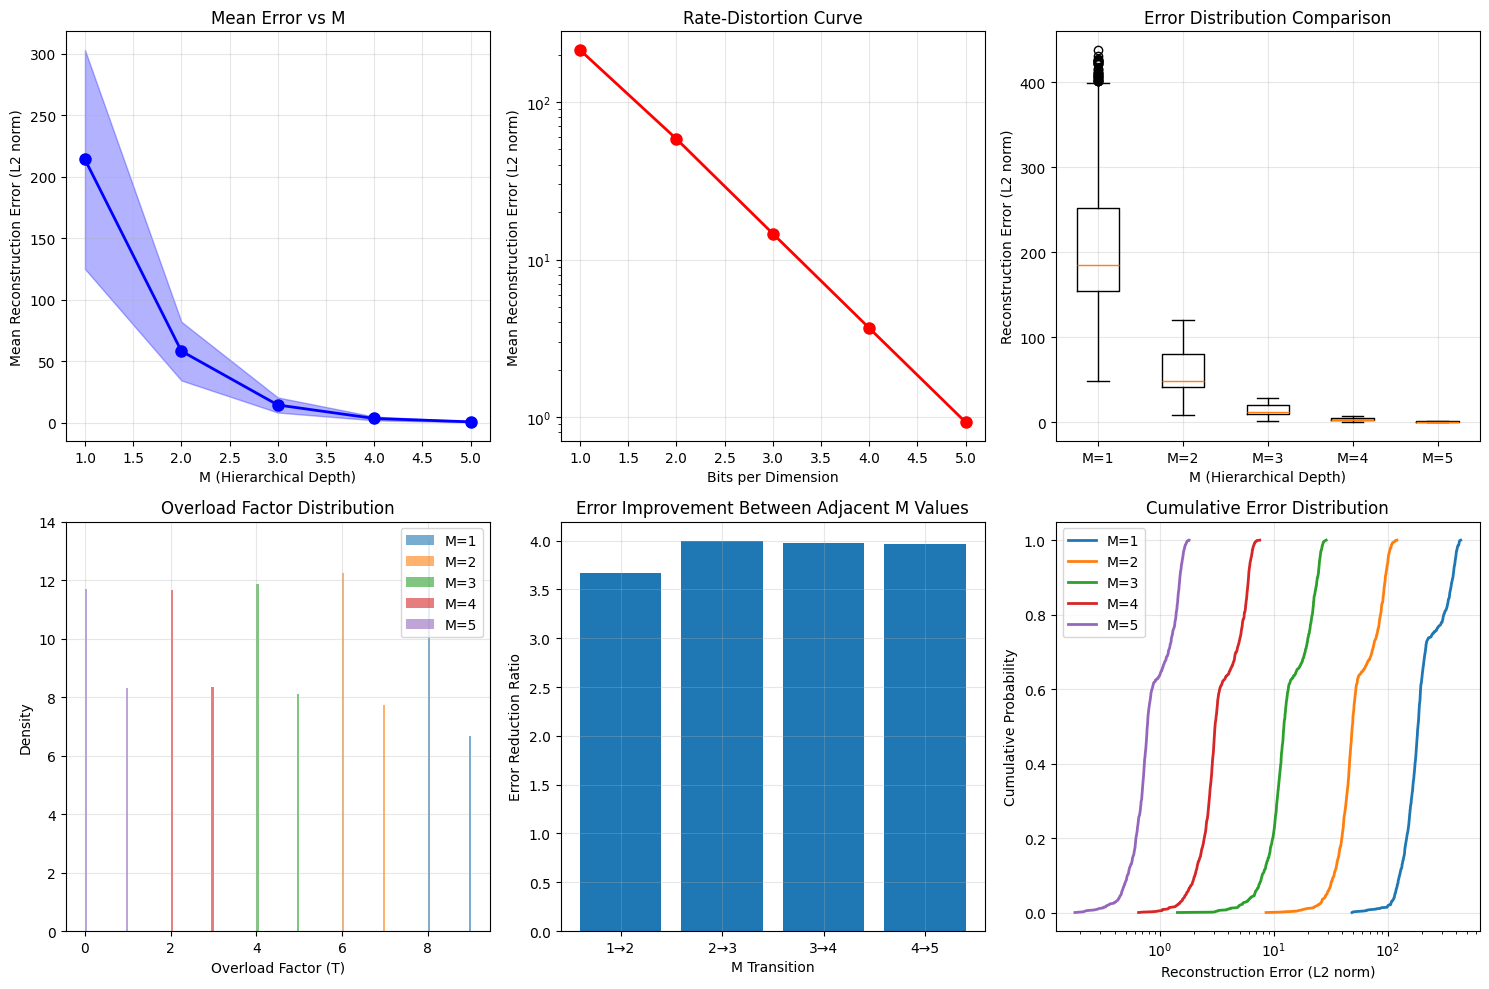


=== Additional Statistics ===
M=1: Perfect reconstructions: 0/1000 (0.0%)
M=2: Perfect reconstructions: 0/1000 (0.0%)
M=3: Perfect reconstructions: 0/1000 (0.0%)
M=4: Perfect reconstructions: 0/1000 (0.0%)
M=5: Perfect reconstructions: 0/1000 (0.0%)

=== Error Improvement Analysis ===
M=1 → M=2: Error reduction = 155.703473 (3.67x improvement)
M=2 → M=3: Error reduction = 43.774813 (4.00x improvement)
M=3 → M=4: Error reduction = 10.939673 (3.98x improvement)
M=4 → M=5: Error reduction = 2.745470 (3.96x improvement)


In [13]:
def run_hnlq_m_comparison(pre_scale, N=1000, M_values=[1, 2, 3, 4, 5], q=4, d=4, 
                         lattice_type='D4', seed=31, save_results=False):
    """
    Run HNLQ quantizer comparison for different M values.
    
    Parameters:
    -----------
    N : int
        Number of samples to generate
    M_values : list
        List of M values to test
    q : int
        Quantization parameter
    d : int
        Dimension of the vectors
    lattice_type : str
        Type of lattice to use ('D4', 'Z2', etc.)
    seed : int
        Random seed for reproducibility
    save_results : bool
        Whether to save results to CSV file
    
    Returns:
    --------
    dict : Results dictionary containing errors, statistics, and DataFrame
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from gemvq.quantizers.hnlq import HNLQ as Quantizer
    from gemvq.quantizers.hnlq import HNLQConfig as QuantizerConfig
    
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Generate N random samples, normalize to norm 1, then scale by q^M
    samples_raw = np.random.normal(0, 1.0, size=(N, d))
    # Normalize each sample to unit norm
    samples_normalized = samples_raw / np.linalg.norm(samples_raw, axis=1, keepdims=True)
    # Scale by q^M (using max M for scaling)
    max_M = max(M_values)
    if pre_scale is None:
        pre_scale = [q ** max_M/np.sqrt(2)] * len(M_values) 
    
    print(f"Testing M values: {M_values}")
    print(f"Pre-scaling factors: {pre_scale}")
    # Initialize results storage
    results = {}
    
    # Process each M value
    for M in M_values:
        print(f"\n=== Processing M = {M} ===")
        samples = samples_normalized * pre_scale[M-1]
        # Create HNLQ quantizer configuration
        config = QuantizerConfig(
            lattice_type=lattice_type,
            q=q,
            M=M,
            beta=1.0,
            alpha=1.0,
            overload=True,
            decoding='full',
            with_tie_dither=True
        )
        
        # Create quantizer
        quantizer = Quantizer(config)
        
        # Initialize arrays to store results for this M
        errors = np.zeros(N)
        overload_factors = np.zeros(N)
        
        # Process each sample
        for i in range(N):
            if i % 200 == 0:
                print(f"  Processing sample {i}/{N}")
            
            x = samples[i]
            
            # Encode the sample
            enc, T = quantizer.encode(x)
            overload_factors[i] = T
            
            # Decode using full decoding (not coarse_to_fine or progressive)
            xh = quantizer.decode(enc, T)
            
            # Calculate error (L2 norm)
            error = np.linalg.norm(x - xh)
            errors[i] = error
        
        # Store results for this M
        results[M] = {
            'errors': errors,
            'overload_factors': overload_factors,
            'mean_error': np.mean(errors),
            'std_error': np.std(errors),
            'median_error': np.median(errors),
            'bits_per_dim': M
        }
        
        print(f"  M={M}: Mean error = {results[M]['mean_error']:.6f}, "
              f"Std error = {results[M]['std_error']:.6f}")
    
    # Create results DataFrame
    results_data = []
    for M in M_values:
        results_data.append({
            'M': M,
            'Bits_per_Dimension': M,
            'Mean_Error': results[M]['mean_error'],
            'Std_Error': results[M]['std_error'],
            'Median_Error': results[M]['median_error']
        })
    
    results_df = pd.DataFrame(results_data)
    
    print("\n=== Results Summary ===")
    print(results_df)
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Mean error vs M
    plt.subplot(2, 3, 1)
    M_list = list(results.keys())
    mean_errors = [results[M]['mean_error'] for M in M_list]
    std_errors = [results[M]['std_error'] for M in M_list]
    
    plt.plot(M_list, mean_errors, 'bo-', linewidth=2, markersize=8)
    plt.fill_between(M_list, 
                     [mean_errors[i] - std_errors[i] for i in range(len(M_list))], 
                     [mean_errors[i] + std_errors[i] for i in range(len(M_list))], 
                     alpha=0.3, color='blue')
    plt.xlabel('M (Hierarchical Depth)')
    plt.ylabel('Mean Reconstruction Error (L2 norm)')
    plt.title('Mean Error vs M')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Rate-distortion curve
    plt.subplot(2, 3, 2)
    bits_per_dim = [results[M]['bits_per_dim'] for M in M_list]
    plt.plot(bits_per_dim, mean_errors, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Bits per Dimension')
    plt.ylabel('Mean Reconstruction Error (L2 norm)')
    plt.title('Rate-Distortion Curve')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 3: Error distribution comparison
    plt.subplot(2, 3, 3)
    error_data = [results[M]['errors'] for M in M_list]
    plt.boxplot(error_data, labels=[f'M={M}' for M in M_list])
    plt.xlabel('M (Hierarchical Depth)')
    plt.ylabel('Reconstruction Error (L2 norm)')
    plt.title('Error Distribution Comparison')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Overload factor distribution for each M
    plt.subplot(2, 3, 4)
    for M in M_list:
        plt.hist(results[M]['overload_factors'], bins=20, alpha=0.6, 
                 label=f'M={M}', density=True)
    plt.xlabel('Overload Factor (T)')
    plt.ylabel('Density')
    plt.title('Overload Factor Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Error improvement ratio
    plt.subplot(2, 3, 5)
    improvement_ratios = []
    for i in range(len(M_list) - 1):
        ratio = results[M_list[i]]['mean_error'] / results[M_list[i+1]]['mean_error']
        improvement_ratios.append(ratio)
    
    plt.bar(range(len(improvement_ratios)), improvement_ratios, 
            tick_label=[f'{M_list[i]}→{M_list[i+1]}' for i in range(len(improvement_ratios))])
    plt.xlabel('M Transition')
    plt.ylabel('Error Reduction Ratio')
    plt.title('Error Improvement Between Adjacent M Values')
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Cumulative error statistics
    plt.subplot(2, 3, 6)
    for M in M_list:
        sorted_errors = np.sort(results[M]['errors'])
        cumulative_prob = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
        plt.plot(sorted_errors, cumulative_prob, label=f'M={M}', linewidth=2)
    
    plt.xlabel('Reconstruction Error (L2 norm)')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis
    print(f"\n=== Additional Statistics ===")
    for M in M_list:
        perfect_reconstructions = np.sum(results[M]['errors'] < 1e-10)
        print(f"M={M}: Perfect reconstructions: {perfect_reconstructions}/{N} "
              f"({100*perfect_reconstructions/N:.1f}%)")
    
    print(f"\n=== Error Improvement Analysis ===")
    for i in range(len(M_list) - 1):
        current_M = M_list[i]
        next_M = M_list[i + 1]
        improvement = results[current_M]['mean_error'] - results[next_M]['mean_error']
        improvement_ratio = results[current_M]['mean_error'] / results[next_M]['mean_error']
        print(f"M={current_M} → M={next_M}: Error reduction = {improvement:.6f} "
              f"({improvement_ratio:.2f}x improvement)")
    
    # Save results to CSV if requested
    if save_results:
        filename = f'hnlq_m_comparison_results_{lattice_type}_q{q}_N{N}.csv'
        results_df.to_csv(filename, index=False)
        print(f"\nResults saved to '{filename}'")
    
    return {
        'results': results,
        'dataframe': results_df,
        'samples': samples,
        'config': {
            'N': N,
            'M_values': M_values,
            'q': q,
            'd': d,
            'lattice_type': lattice_type,
            'seed': seed
        }
    }

# Example usage:

results = run_hnlq_m_comparison(None, N=1000, M_values=[1, 2, 3, 4, 5], q=4, d=4)

Testing M values: [1, 2, 3, 4, 5]
Pre-scaling factors: [1, 1, 1, 1, 1]

=== Processing M = 1 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=1: Mean error = 0.681265, Std error = 0.109559

=== Processing M = 2 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=2: Mean error = 0.681265, Std error = 0.109559

=== Processing M = 3 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=3: Mean error = 0.681265, Std error = 0.109559

=== Processing M = 4 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=4: Mean error = 0.681265, Std error = 0.109559

=== Processing M = 5 ===
  Processing sample 0/1

/var/folders/vl/8_b839fx467b9mn0g_w2wb8r0000gn/T/ipykernel_38168/240450202.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_data, labels=[f'M={M}' for M in M_list])


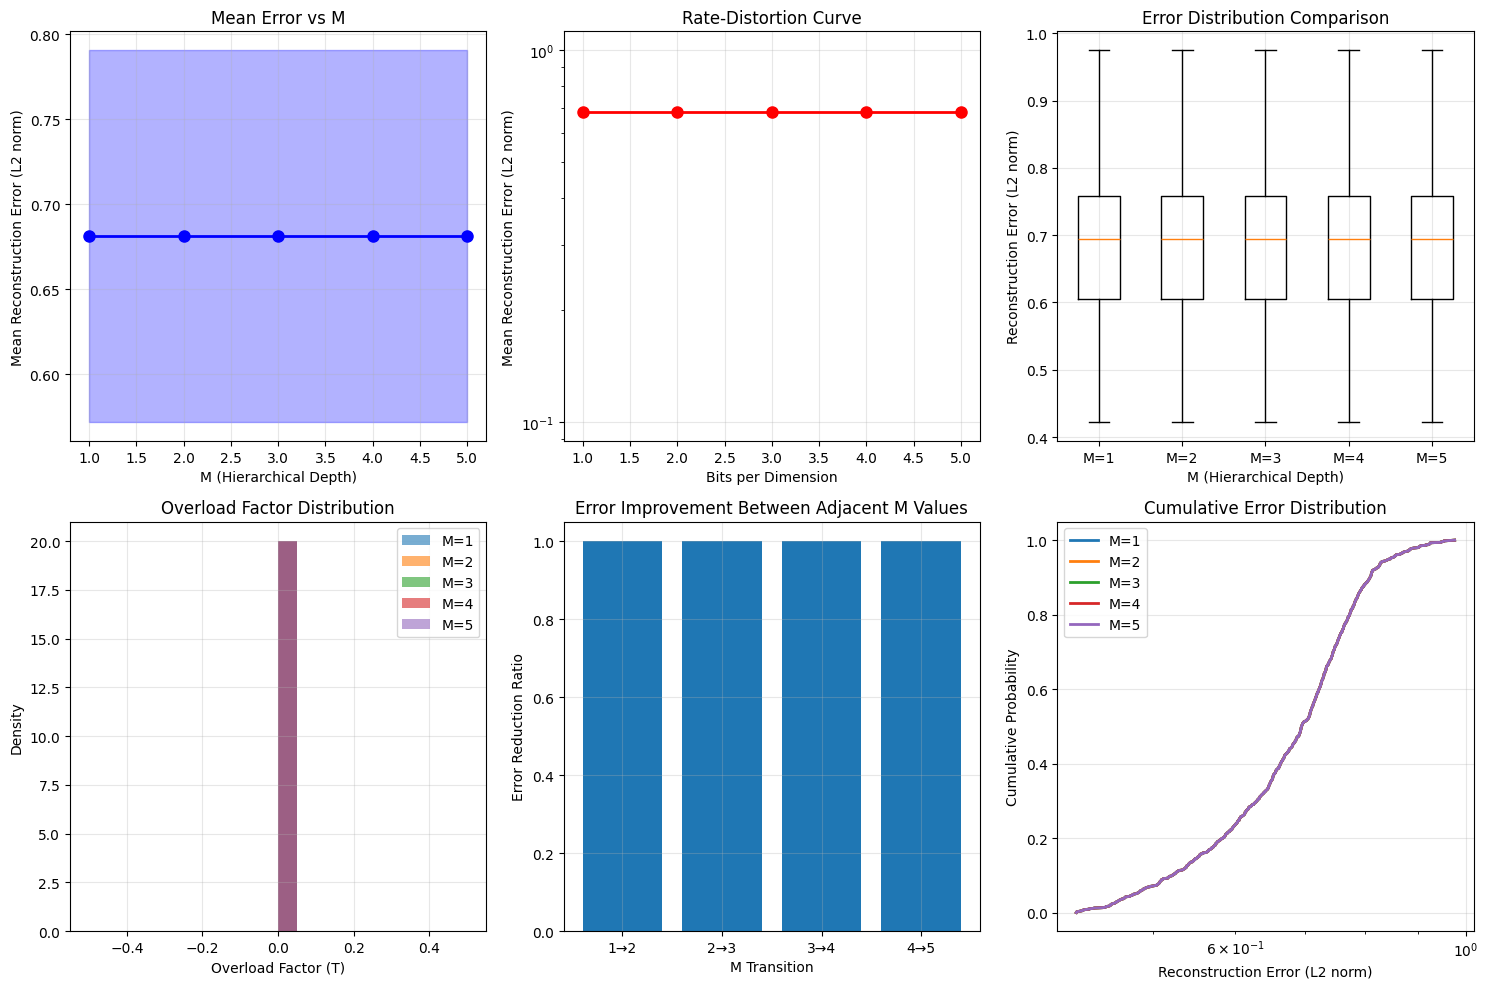


=== Additional Statistics ===
M=1: Perfect reconstructions: 0/1000 (0.0%)
M=2: Perfect reconstructions: 0/1000 (0.0%)
M=3: Perfect reconstructions: 0/1000 (0.0%)
M=4: Perfect reconstructions: 0/1000 (0.0%)
M=5: Perfect reconstructions: 0/1000 (0.0%)

=== Error Improvement Analysis ===
M=1 → M=2: Error reduction = 0.000000 (1.00x improvement)
M=2 → M=3: Error reduction = 0.000000 (1.00x improvement)
M=3 → M=4: Error reduction = 0.000000 (1.00x improvement)
M=4 → M=5: Error reduction = 0.000000 (1.00x improvement)


In [14]:
# run with the same analysis but with unit norm
pre_scale = [1] * 5
results = run_hnlq_m_comparison(pre_scale, N=1000, M_values=[1, 2, 3, 4, 5], q=4, d=4)

Indeed. For given lattice, and q, when norm (hence the dynamic range of the input is lower), increasing the depth does not help. Notice that the overloading factor is not activated at all.

So pre-scaling the inputs is necessary, depending on 

- lattice
- desired bit rate per dimension
- codebook size 
- depth

For a given, lattice, q, we need to compare how pre-scaling helps. For this, for each depth, we need to get the distortion and relative distortion.

=== Strategy 1: Scale by q^M ===
Testing M values: [1, 2, 3, 4, 5]
Pre-scaling factors: [4, 16, 64, 256, 1024]

=== Processing M = 1 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=1: Mean error = 1.291686, Mean relative error = 0.322921

=== Processing M = 2 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=2: Mean error = 1.255118, Mean relative error = 0.078445

=== Processing M = 3 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=3: Mean error = 1.274930, Mean relative error = 0.019921

=== Processing M = 4 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=4: Mean error = 1.258273, 

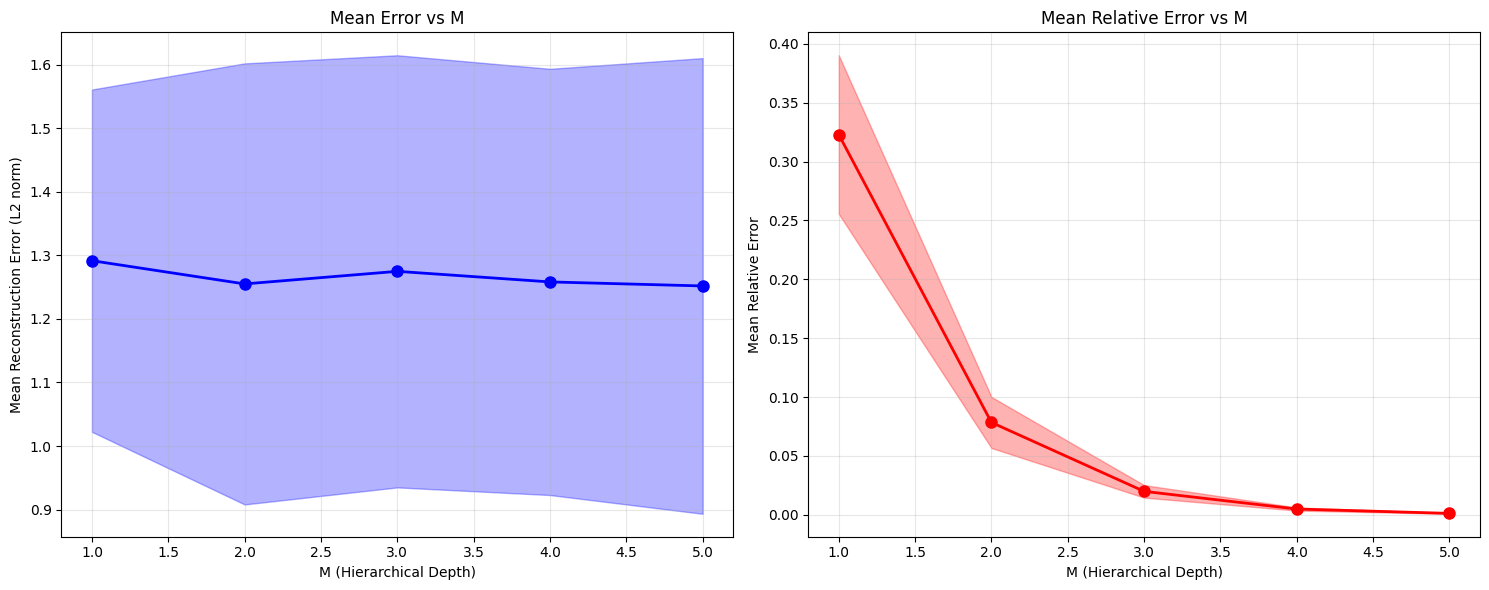


=== Error Improvement Analysis ===
M=1 → M=2:
  Absolute error: reduction = 0.036568 (1.03x improvement)
  Relative error: reduction = 0.244477 (4.12x improvement)
M=2 → M=3:
  Absolute error: reduction = -0.019812 (0.98x improvement)
  Relative error: reduction = 0.058524 (3.94x improvement)
M=3 → M=4:
  Absolute error: reduction = 0.016657 (1.01x improvement)
  Relative error: reduction = 0.015006 (4.05x improvement)
M=4 → M=5:
  Absolute error: reduction = 0.006352 (1.01x improvement)
  Relative error: reduction = 0.003693 (4.02x improvement)

=== Strategy 2: Scale by q^M/sqrt(2) ===
Testing M values: [1, 2, 3, 4, 5]
Pre-scaling factors: [np.float64(2.82842712474619), np.float64(11.31370849898476), np.float64(45.25483399593904), np.float64(181.01933598375615), np.float64(724.0773439350246)]

=== Processing M = 1 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=1: Mean error = 0.836

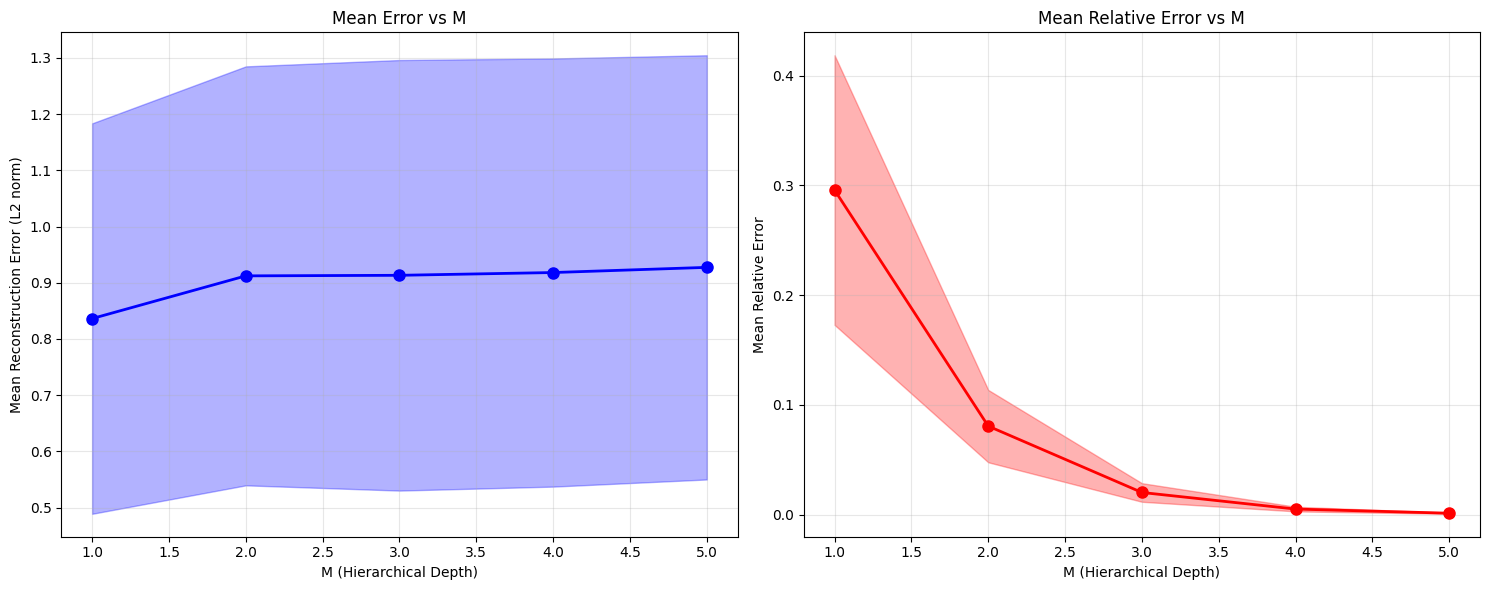


=== Error Improvement Analysis ===
M=1 → M=2:
  Absolute error: reduction = -0.076010 (0.92x improvement)
  Relative error: reduction = 0.215037 (3.67x improvement)
M=2 → M=3:
  Absolute error: reduction = -0.000983 (1.00x improvement)
  Relative error: reduction = 0.060456 (4.00x improvement)
M=3 → M=4:
  Absolute error: reduction = -0.004938 (0.99x improvement)
  Relative error: reduction = 0.015108 (3.98x improvement)
M=4 → M=5:
  Absolute error: reduction = -0.009201 (0.99x improvement)
  Relative error: reduction = 0.003792 (3.96x improvement)

=== Strategy 3: Constant scaling (q^5/sqrt(2)) ===
Testing M values: [1, 2, 3, 4, 5]
Pre-scaling factors: [np.float64(724.0773439350246), np.float64(724.0773439350246), np.float64(724.0773439350246), np.float64(724.0773439350246), np.float64(724.0773439350246)]

=== Processing M = 1 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=1: Mean 

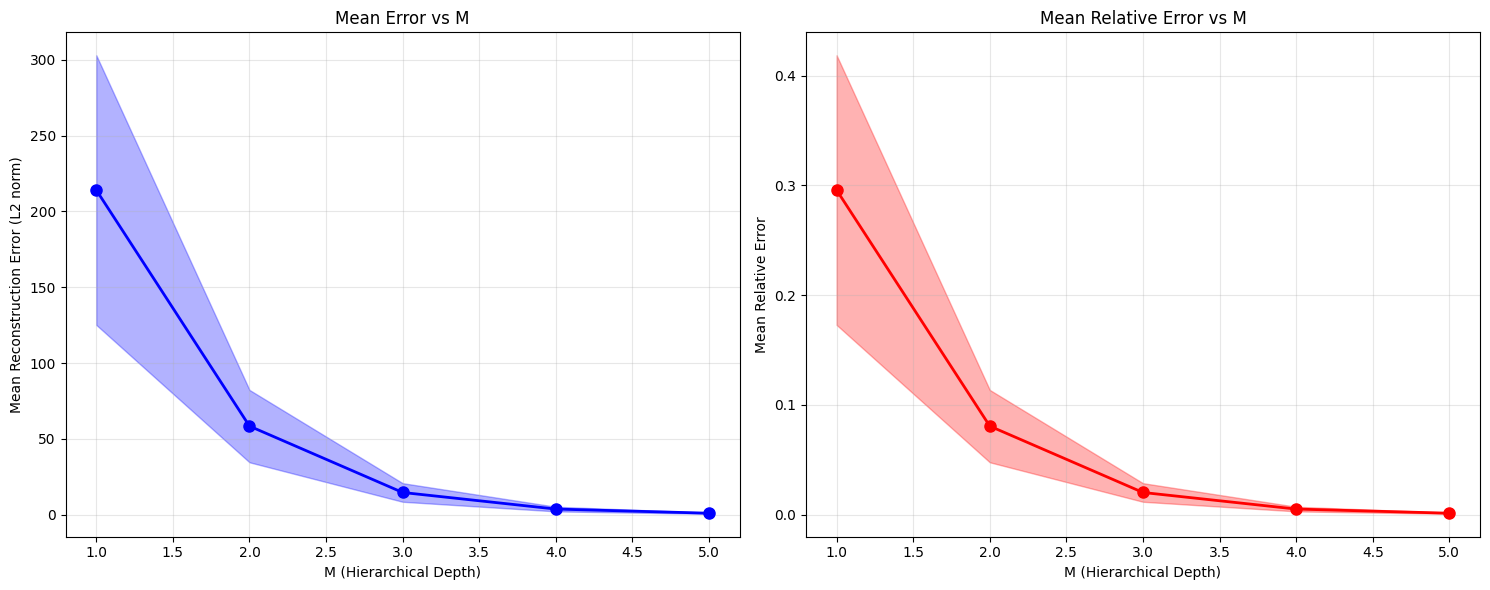


=== Error Improvement Analysis ===
M=1 → M=2:
  Absolute error: reduction = 155.703473 (3.67x improvement)
  Relative error: reduction = 0.215037 (3.67x improvement)
M=2 → M=3:
  Absolute error: reduction = 43.774813 (4.00x improvement)
  Relative error: reduction = 0.060456 (4.00x improvement)
M=3 → M=4:
  Absolute error: reduction = 10.939673 (3.98x improvement)
  Relative error: reduction = 0.015108 (3.98x improvement)
M=4 → M=5:
  Absolute error: reduction = 2.745470 (3.96x improvement)
  Relative error: reduction = 0.003792 (3.96x improvement)

=== Strategy 4: Unit norm ===
Testing M values: [1, 2, 3, 4, 5]
Pre-scaling factors: [1.0, 1.0, 1.0, 1.0, 1.0]

=== Processing M = 1 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 400/1000
  Processing sample 600/1000
  Processing sample 800/1000
  M=1: Mean error = 0.681265, Mean relative error = 0.681265

=== Processing M = 2 ===
  Processing sample 0/1000
  Processing sample 200/1000
  Processing sample 

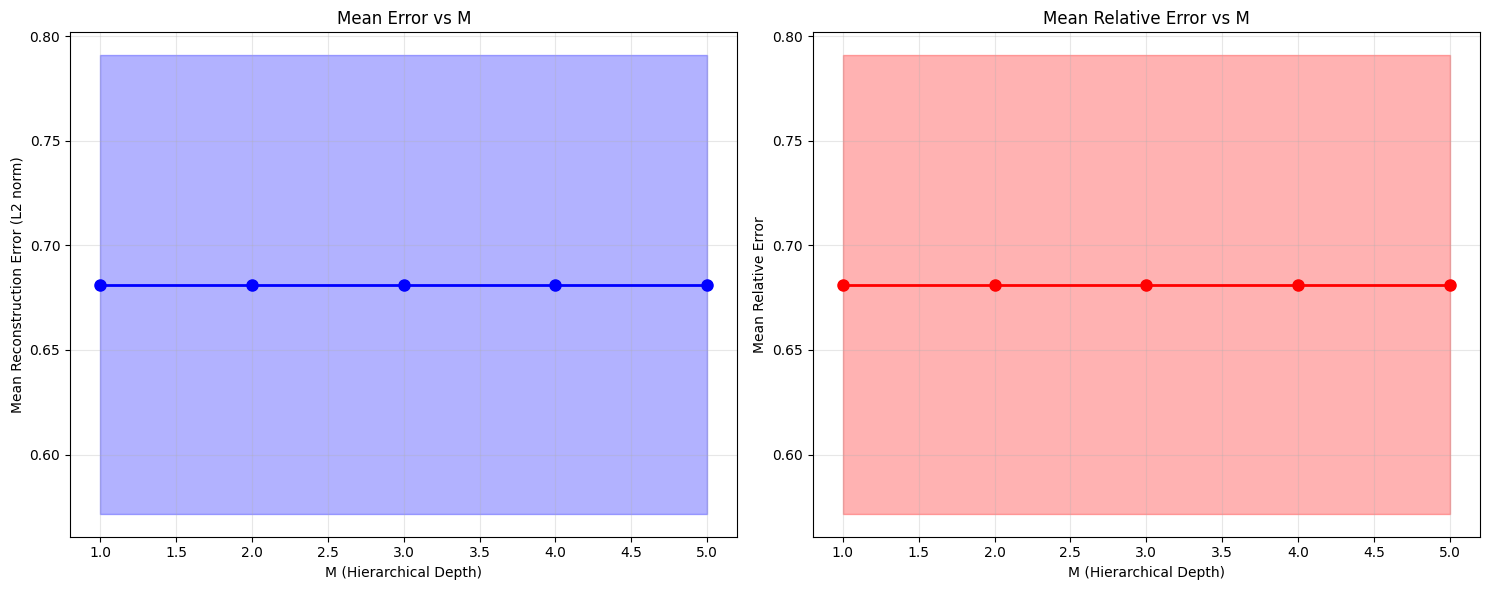


=== Error Improvement Analysis ===
M=1 → M=2:
  Absolute error: reduction = 0.000000 (1.00x improvement)
  Relative error: reduction = 0.000000 (1.00x improvement)
M=2 → M=3:
  Absolute error: reduction = 0.000000 (1.00x improvement)
  Relative error: reduction = 0.000000 (1.00x improvement)
M=3 → M=4:
  Absolute error: reduction = 0.000000 (1.00x improvement)
  Relative error: reduction = 0.000000 (1.00x improvement)
M=4 → M=5:
  Absolute error: reduction = 0.000000 (1.00x improvement)
  Relative error: reduction = 0.000000 (1.00x improvement)


In [15]:
def run_hnlq_m_error_analysis(pre_scales, N=1000, M_values=[1, 2, 3, 4, 5], q=4, d=4, 
                             lattice_type='D4', seed=31):
    """
    Run HNLQ quantizer analysis for different M values, computing mean error and mean relative error.
    
    Parameters:
    -----------
    pre_scales : list
        List of pre-scaling factors of length 5 (one for each M value)
    N : int
        Number of samples to generate
    M_values : list
        List of M values to test (default: [1, 2, 3, 4, 5])
    q : int
        Quantization parameter
    d : int
        Dimension of the vectors
    lattice_type : str
        Type of lattice to use ('D4', 'Z2', etc.)
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Results dictionary containing errors, relative errors, and statistics
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from gemvq.quantizers.hnlq import HNLQ as Quantizer
    from gemvq.quantizers.hnlq import HNLQConfig as QuantizerConfig
    
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Validate pre_scales
    if len(pre_scales) != len(M_values):
        raise ValueError(f"pre_scales must have length {len(M_values)}, got {len(pre_scales)}")
    
    print(f"Testing M values: {M_values}")
    print(f"Pre-scaling factors: {pre_scales}")
    
    # Generate N random samples, normalize to norm 1
    samples_raw = np.random.normal(0, 1.0, size=(N, d))
    samples_normalized = samples_raw / np.linalg.norm(samples_raw, axis=1, keepdims=True)
    
    # Initialize results storage
    results = {}
    
    # Process each M value
    for idx, M in enumerate(M_values):
        print(f"\n=== Processing M = {M} ===")
        
        # Scale samples by the corresponding pre_scale factor
        samples = samples_normalized * pre_scales[idx]
        
        # Create HNLQ quantizer configuration
        config = QuantizerConfig(
            lattice_type=lattice_type,
            q=q,
            M=M,
            beta=1.0,
            alpha=1.0,
            overload=True,
            decoding='full',
            with_tie_dither=True
        )
        
        # Create quantizer
        quantizer = Quantizer(config)
        
        # Initialize arrays to store results for this M
        errors = np.zeros(N)
        relative_errors = np.zeros(N)
        overload_factors = np.zeros(N)
        
        # Process each sample
        for i in range(N):
            if i % 200 == 0:
                print(f"  Processing sample {i}/{N}")
            
            x = samples[i]
            x_norm = np.linalg.norm(x)
            
            # Encode the sample
            enc, T = quantizer.encode(x)
            overload_factors[i] = T
            
            # Decode using full decoding
            xh = quantizer.decode(enc, T)
            
            # Calculate absolute error (L2 norm)
            error = np.linalg.norm(x - xh)
            errors[i] = error
            
            # Calculate relative error
            relative_error = error / x_norm if x_norm > 0 else 0
            relative_errors[i] = relative_error
        
        # Store results for this M
        results[M] = {
            'errors': errors,
            'relative_errors': relative_errors,
            'overload_factors': overload_factors,
            'mean_error': np.mean(errors),
            'std_error': np.std(errors),
            'mean_relative_error': np.mean(relative_errors),
            'std_relative_error': np.std(relative_errors),
            'bits_per_dim': M
        }
        
        print(f"  M={M}: Mean error = {results[M]['mean_error']:.6f}, "
              f"Mean relative error = {results[M]['mean_relative_error']:.6f}")
    
    # Create results DataFrame
    results_data = []
    for M in M_values:
        results_data.append({
            'M': M,
            'Bits_per_Dimension': M,
            'Mean_Error': results[M]['mean_error'],
            'Std_Error': results[M]['std_error'],
            'Mean_Relative_Error': results[M]['mean_relative_error'],
            'Std_Relative_Error': results[M]['std_relative_error']
        })
    
    results_df = pd.DataFrame(results_data)
    
    print("\n=== Results Summary ===")
    print(results_df)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Mean error vs M
    plt.subplot(1, 2, 1)
    M_list = list(results.keys())
    mean_errors = [results[M]['mean_error'] for M in M_list]
    std_errors = [results[M]['std_error'] for M in M_list]
    
    plt.plot(M_list, mean_errors, 'bo-', linewidth=2, markersize=8)
    plt.fill_between(M_list, 
                     [mean_errors[i] - std_errors[i] for i in range(len(M_list))], 
                     [mean_errors[i] + std_errors[i] for i in range(len(M_list))], 
                     alpha=0.3, color='blue')
    plt.xlabel('M (Hierarchical Depth)')
    plt.ylabel('Mean Reconstruction Error (L2 norm)')
    plt.title('Mean Error vs M')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Mean relative error vs M
    plt.subplot(1, 2, 2)
    mean_relative_errors = [results[M]['mean_relative_error'] for M in M_list]
    std_relative_errors = [results[M]['std_relative_error'] for M in M_list]
    
    plt.plot(M_list, mean_relative_errors, 'ro-', linewidth=2, markersize=8)
    plt.fill_between(M_list, 
                     [mean_relative_errors[i] - std_relative_errors[i] for i in range(len(M_list))], 
                     [mean_relative_errors[i] + std_relative_errors[i] for i in range(len(M_list))], 
                     alpha=0.3, color='red')
    plt.xlabel('M (Hierarchical Depth)')
    plt.ylabel('Mean Relative Error')
    plt.title('Mean Relative Error vs M')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis
    print(f"\n=== Error Improvement Analysis ===")
    for i in range(len(M_list) - 1):
        current_M = M_list[i]
        next_M = M_list[i + 1]
        
        # Absolute error improvement
        abs_improvement = results[current_M]['mean_error'] - results[next_M]['mean_error']
        abs_improvement_ratio = results[current_M]['mean_error'] / results[next_M]['mean_error']
        
        # Relative error improvement
        rel_improvement = results[current_M]['mean_relative_error'] - results[next_M]['mean_relative_error']
        rel_improvement_ratio = results[current_M]['mean_relative_error'] / results[next_M]['mean_relative_error']
        
        print(f"M={current_M} → M={next_M}:")
        print(f"  Absolute error: reduction = {abs_improvement:.6f} ({abs_improvement_ratio:.2f}x improvement)")
        print(f"  Relative error: reduction = {rel_improvement:.6f} ({rel_improvement_ratio:.2f}x improvement)")
    
    return {
        'results': results,
        'dataframe': results_df,
        'config': {
            'N': N,
            'M_values': M_values,
            'q': q,
            'd': d,
            'lattice_type': lattice_type,
            'seed': seed,
            'pre_scales': pre_scales
        }
    }

# Example usage with different pre-scaling strategies:

# Strategy 1: Scale by q^M for each M value
q = 4
pre_scales_qm = [q**M for M in [1, 2, 3, 4, 5]]
print("=== Strategy 1: Scale by q^M ===")
results1 = run_hnlq_m_error_analysis(pre_scales_qm, N=1000, q=q, d=4)

# Strategy 2: Scale by q^M/sqrt(2) for each M value (as in the original notebook)
pre_scales_qm_sqrt2 = [q**M/np.sqrt(2) for M in [1, 2, 3, 4, 5]]
print("\n=== Strategy 2: Scale by q^M/sqrt(2) ===")
results2 = run_hnlq_m_error_analysis(pre_scales_qm_sqrt2, N=1000, q=q, d=4)

# Strategy 3: Constant scaling (all inputs have same norm)
pre_scales_constant = [q**5/np.sqrt(2)] * 5  # Use max M scaling for all
print("\n=== Strategy 3: Constant scaling (q^5/sqrt(2)) ===")
results3 = run_hnlq_m_error_analysis(pre_scales_constant, N=1000, q=q, d=4)

# Strategy 4: Unit norm (no scaling)
pre_scales_unit = [1.0] * 5
print("\n=== Strategy 4: Unit norm ===")
results4 = run_hnlq_m_error_analysis(pre_scales_unit, N=1000, q=q, d=4)

Take-aways

- For large input norm, both absolute and relative error decreases
- When input norm is within the recommended range, absolute error is constant, but relative error decreases
- When input norm is small, neither absolute error nor relative error decrease

suggesting that pre-scaling ie necessary despite overload detection is active.